In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import scipy.stats as sts


Bad key "text.kerning_factor" on line 4 in
/Users/juminichelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Importing dataset
raw_data = pd.read_csv('LBA_data.csv')
raw_data.head(5)

,Your name,Neighborhood,City,Grocery store,Apple 1 quantity,Apple 1 price,Apple 2 quantity,Apple 2 price,Apple 3 quantity,Apple 3 price,...,Egg 2 quantity,Egg 2 price,Egg 3 quantity,Egg 3 price,Chicken 1 quantity,Chicken 1 price,Chicken 2 quantity,Chicken 2 price,Chicken 3 quantity,Chicken 3 price
0,Antonio Stark,Zhongzheng District,Taipei,Carrefour,0.20,78.0,0.22,50.0,0.17,30.0,...,10.0,124.00,10.0,104.00,0.3,138.0,0.3,150.0,0.405,176.0
1,Johannes Halkenhaeusser,Retiro,Buenos Aires,Carrefour,1.00,69.9,1.00,86.0,1.00,50.0,...,1.0,9.17,1.0,10.25,1.0,239.9,1.0,304.9,NaN,NaN
2,Giovanna Chaves,Zhonghe District,Taipei,Carrefour,0.16,32.0,0.26,40.0,0.35,78.0,...,10.0,170.00,10.0,170.00,0.3,138.0,0.4,240.0,0.300,380.0
3,Kay,Wanhua District,Taipei,Carrefour,0.25,70.0,0.29,118.0,0.20,26.0,...,8.0,216.00,10.0,280.00,0.3,398.0,0.3,380.0,0.500,540.0
4,Elisa Heinrich Mora,Zhongshan District,Taipei,Carrefour,0.15,46.0,0.15,74.0,0.15,78.0,...,10.0,238.00,10.0,170.00,0.3,130.0,0.3,138.0,0.300,138.0


In [3]:
# Organizing column names to iterate over

products = ["Apple", "Banana", "Tomato", "Potato", "Flour", "Rice", "Milk", "Butter", "Egg", "Chicken"]
column_name = []

for p in products:
    for i in range(1, 4):
        quantity = p + " " + str(i) + " quantity"
        price = p + " " + str(i) + " price"
        column_name.append([p, quantity, price])

In [4]:
## Concatenating the products into a list

total_data = []

for c in column_name:
    for i in raw_data.index:
        quantity=c[1]
        price=c[2]
        total_data.append([c[0], raw_data[quantity][i], raw_data[price][i],
                            raw_data["Grocery store"][i], raw_data["Neighborhood"][i], raw_data["City"][i]])
        
print(*total_data[:5],sep='\n')

['Apple', 0.2, 78.0, 'Carrefour', 'Zhongzheng District', 'Taipei']
['Apple', 1.0, 69.9, 'Carrefour', 'Retiro', 'Buenos Aires']
['Apple', 0.16, 32.0, 'Carrefour', 'Zhonghe District', 'Taipei']
['Apple', 0.25, 70.0, 'Carrefour', 'Wanhua District', 'Taipei']
['Apple', 0.15, 46.0, 'Carrefour', 'Zhongshan District', 'Taipei']


In [5]:
# Normalizing the quantities and prices
for i in range(len(total_data)):
    # normalize
    if total_data[i][1] != 1 and total_data[i][1] > 0:
        new_price = total_data[i][2]/total_data[i][1]
        total_data[i][1] = 1
        total_data[i][2] = new_price

print(*total_data[:5],sep='\n')

['Apple', 1, 390.0, 'Carrefour', 'Zhongzheng District', 'Taipei']
['Apple', 1.0, 69.9, 'Carrefour', 'Retiro', 'Buenos Aires']
['Apple', 1, 200.0, 'Carrefour', 'Zhonghe District', 'Taipei']
['Apple', 1, 280.0, 'Carrefour', 'Wanhua District', 'Taipei']
['Apple', 1, 306.6666666666667, 'Carrefour', 'Zhongshan District', 'Taipei']


In [6]:
# Creating a dictionary
dict_data = pd.DataFrame()

# PRODUCT
dict_product=[]
for i in range(len(total_data)):
    dict_product.append(total_data[i][0])
dict_data['Product'] = dict_product

# QUANTITY
dict_quantity=[]
for i in range(len(total_data)):
    dict_quantity.append(total_data[i][1])
dict_data['Quantity'] = dict_quantity

# PRICE
dict_price=[]
for i in range(len(total_data)):
    dict_price.append(total_data[i][2])
dict_data['Price'] = dict_price

# GROCERY STORE
dict_store=[]
for i in range(len(total_data)):
    dict_store.append(total_data[i][3])
dict_data['Grocery Store'] = dict_store

# NEIGHBORHOOD
dict_neighborhood=[]
for i in range(len(total_data)):
    dict_neighborhood.append(total_data[i][4])
dict_data['Neighborhood'] = dict_neighborhood

# CITY
dict_city=[]
for i in range(len(total_data)):
    dict_city.append(total_data[i][5])
dict_data['City'] = dict_city

In [7]:
previous_len = len(dict_data)
dict_data = dict_data.dropna()
current_len = len(dict_data)

print(f"There were {previous_len - current_len} missing observations.")
print(f"The current dataset has {current_len} observations.")

There were 296 missing observations.
The current dataset has 904 observations.


In [8]:
dict_data.head(15)

,Product,Quantity,Price,Grocery Store,Neighborhood,City
0,Apple,1.0,390.000000,Carrefour,Zhongzheng District,Taipei
1,Apple,1.0,69.900000,Carrefour,Retiro,Buenos Aires
2,Apple,1.0,200.000000,Carrefour,Zhonghe District,Taipei
3,Apple,1.0,280.000000,Carrefour,Wanhua District,Taipei
4,Apple,1.0,306.666667,Carrefour,Zhongshan District,Taipei
5,Apple,1.0,384.615385,Carrefour,Yonghe District,Taipei
6,Apple,1.0,69.900000,Carrefour,Recoleta,Buenos Aires
7,Apple,1.0,86.000000,Carrefour,Recoleta,Buenos Aires
8,Apple,1.0,72.400000,Carrefour,Recoleta,Buenos Aires
9,Apple,1.0,60.000000,Carrefour,Palermo,Buenos Aires


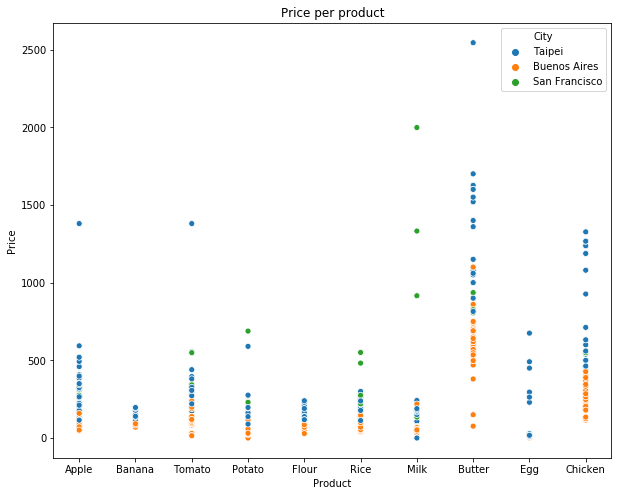

In [9]:
## Plotting key variables to search for outliers
plt.figure(figsize=(10,8))
g = sns.scatterplot(x="Product", y="Price",
              hue="City",
              data=dict_data)
plt.title("Price per product")
plt.show()

In [10]:
# Transform numerical data into categorical data
dict_data["Product"] = dict_data["Product"].astype('category')
dict_data["Neighborhood"] = dict_data["Neighborhood"].astype('category')
dict_data["Grocery Store"] = dict_data["Grocery Store"].astype('category')
dict_data["City"] = dict_data["City"].astype('category')

categorical_data = dict_data.select_dtypes(["category"]).columns
dict_data[categorical_data] = dict_data[categorical_data].apply(lambda x: x.cat.codes)

# Adding one to avoid 0s in the model
dict_data["Neighborhood"] = dict_data["Neighborhood"].apply(lambda x: x+1)
dict_data["Grocery Store"] = dict_data["Grocery Store"].apply(lambda x: x+1)
dict_data["Product"] = dict_data["Product"].apply(lambda x: x+1)
dict_data["City"] = dict_data["City"].apply(lambda x: x+1)

In [11]:
dict_data.to_csv(r'clean_data.csv')

In [12]:
input_data = {
    "price" : dict_data["Price"].tolist(),
    "neighborhood" : dict_data["Neighborhood"].tolist(),
    "grocery" : dict_data["Grocery Store"].tolist(),
    "product" : dict_data["Product"].tolist(),
    "product_count" : len(products),
    "grocery_count" : len(set(dict_data["Grocery Store"].tolist())),
    "neighborhood_count" : len(set(dict_data["Neighborhood"].tolist())),
    "row_count" : len(dict_data.index),
    "alpha_base" : 1.5,
    "beta_base" : 0.003,
    "alpha" : 4,
    "beta" : 4, 
    "loc_error": 0.1,
    "scale_error": 10}